In [273]:
%matplotlib inline
from matplotlib import pyplot as plt
import pandas as pd
from datetime import date, datetime
from lifelines import KaplanMeierFitter, CoxPHFitter, NelsonAalenFitter

plt.style.use('bmh')

In [238]:
# quitting is death, all else is censoring

In [239]:
raw_df = pd.read_csv("https://raw.githubusercontent.com/fivethirtyeight/data/master/cabinet-turnover/cabinet-turnover.csv",
                    na_values=['Still in office', '#VALUE!']
                    )
TODAY = datetime.today().date()

INAUG_DATES = {
    'Trump': date(2017, 1, 20),
    'Obama': date(2009, 1, 20),
    'Bush 43': date(2001, 1, 20),
    'Clinton': date(1993, 1, 20),
    'Bush 41': date(1989, 1, 20),
    'Reagan': date(1981, 1, 20),
    'Carter': date(1977, 1, 20)
}

In [240]:
def fill_end(series):
    end, president = series
    if pd.notnull(end) and end.endswith('admin'):
        next_pres ,_ = end.split(' ')
        if next_pres == 'Bush':
            next_pres = next_pres + ' 43' if president == 'Clinton' else next_pres + ' 41'
        return INAUG_DATES[next_pres].strftime('%m/%d/%y')
    else:
        return end
    
def fill_start(series):
    end, president = series
    if pd.notnull(end) and end.endswith('admin'):
        prev_pres ,_ = end.split(' ')
        if prev_pres == 'Bush':
            prev_pres = prev_pres + ' 43' if president == 'Obama' else prev_pres + ' 41'
        return INAUG_DATES[president].strftime('%m/%d/%y')
    else:
        return end
    
    
raw_df['end'] = raw_df[['end', 'president']].apply(fill_end, axis=1)
raw_df['start'] = raw_df[['start', 'president']].apply(fill_start, axis=1)

raw_df['end'] = pd.to_datetime(raw_df['end']).dt.date
raw_df['end'] = raw_df['end'].fillna(TODAY)
raw_df['start'] = pd.to_datetime(raw_df['start']).dt.date

In [357]:
inaug_dates = pd.DataFrame(list(INAUG_DATES.items()))
inaug_dates.columns = ['president', 'president_start_date']
inaug_dates['president_end_date'] = inaug_dates['president_start_date'].shift(1).fillna(TODAY)

In [358]:
inaug_dates

,president,president_start_date,president_end_date
0,Trump,2017-01-20,2019-01-08
1,Obama,2009-01-20,2017-01-20
2,Bush 43,2001-01-20,2009-01-20
3,Clinton,1993-01-20,2001-01-20
4,Bush 41,1989-01-20,1993-01-20
5,Reagan,1981-01-20,1989-01-20
6,Carter,1977-01-20,1981-01-20


In [244]:
raw_df = raw_df.merge(inaug_dates, left_on='president', right_on='president')

In [262]:
# we need to "collapse" individuals into rows, because they may change positions, but that's not quitting...
def collapse(df):
    return df.groupby('appointee', as_index=False).aggregate({
        'start': 'min', 'end': 'max', 'event': 'all', 'president': 'last', 'president_end_date': 'last'
    })

raw_df = raw_df.groupby('president', as_index=False).apply(collapse).reset_index(drop=True)


In [286]:
raw_df['event'] = (raw_df['end'] < raw_df['president_end_date']) & pd.notnull(raw_df['end'])
raw_df['T'] = (raw_df['end'] - raw_df['start']).dt.days


(0, 800)

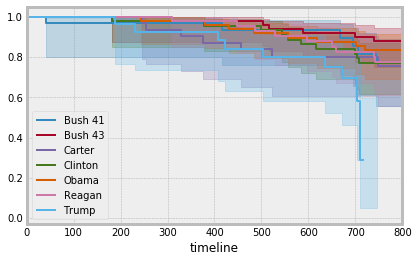

In [359]:
kmf = KaplanMeierFitter()

ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    kmf.fit(df_['T'], df_['event'], label=name)
    ax = kmf.plot(ax=ax)
ax.set_xlim(0, 800)

(0, 800)

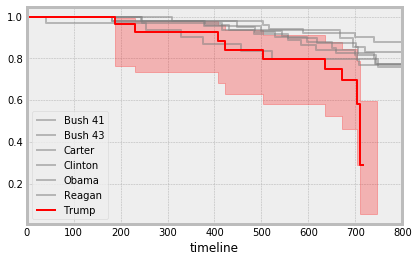

In [360]:
ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    kmf.fit(df_['T'], df_['event'], label=name)
    if name == 'Trump':
        ax = kmf.plot(ax=ax, c='r')
    else:
        ax = kmf.plot(ax=ax, c='grey', alpha=0.5, ci_show=False)
ax.set_xlim(0, 800)

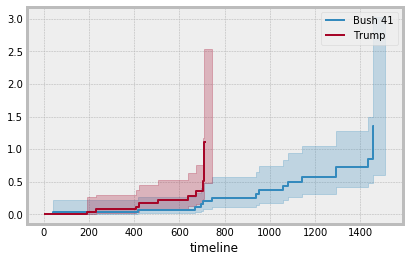

In [371]:
raw_df[['president','event', 'T']]

naf = NelsonAalenFitter()

ax = plt.subplot()

for name, df_ in raw_df[['president','event', 'T']].groupby('president'):
    if name in ['Trump', 'Bush 41']:
        naf.fit(df_['T'], df_['event'], label=name)
        ax = naf.plot(ax=ax)

In [373]:
raw_df['year'] = raw_df['start'].apply(lambda d: int(d.year))
raw_df['bin_year'] = np.cut(raw_df['start']


regression_df = raw_df[['president', 'T', 'event', 'year', 'year**2']]
regression_df = pd.get_dummies(regression_df, columns=['president'])
del regression_df['president_Clinton']

In [374]:
cph = CoxPHFitter()
cph.fit(regression_df, 'T', 'event')
cph.print_summary()

<lifelines.CoxPHFitter: fitted with 287 observations, 129 censored>
      duration col = 'T'
         event col = 'event'
number of subjects = 287
  number of events = 158
    log-likelihood = -722.82
  time fit was run = 2019-01-09 18:23:09 UTC

---
                   coef  exp(coef)  se(coef)     z      p  log(p)  lower 0.95  upper 0.95   
year               0.11       1.12      0.06  1.90   0.06   -2.85       -0.00        0.23   
year**2           -0.01       0.99      0.00 -2.11   0.03   -3.35       -0.01       -0.00  .
president_Bush 41  1.46       4.32      0.49  2.99 <0.005   -5.88        0.50        2.42  *
president_Bush 43 -0.64       0.53      0.54 -1.18   0.24   -1.44       -1.70        0.42   
president_Carter   4.65     105.07      1.43  3.24 <0.005   -6.74        1.84        7.47  *
president_Obama   -1.09       0.34      1.04 -1.05   0.29   -1.22       -3.14        0.95   
president_Reagan   2.40      11.00      0.89  2.70   0.01   -4.98        0.66        4.14  *
presi

In [375]:
cph.check_assumptions(regression_df)

Proportional hazard assumption looks okay.


In [376]:
raw_df.head()

,appointee,start,end,event,president,president_end_date,T,year,year**2
0,Andy Card,1992-03-11,1993-01-20,False,Bush 41,1993-01-20,315,1992,24.860821
1,Barbara Franklin,1992-02-27,1993-01-20,False,Bush 41,1993-01-20,328,1992,24.860821
2,Bill Webster,1989-01-20,1991-08-31,True,Bush 41,1993-01-20,953,1989,63.777198
3,Bob Gates,1991-11-06,1993-01-20,False,Bush 41,1993-01-20,441,1991,35.832947
4,Carla Hills,1989-02-06,1993-01-20,False,Bush 41,1993-01-20,1444,1989,63.777198


In [386]:
raw_df['bin_year'] = pd.cut(raw_df['year'], bins=range(1975, 2025, 5))

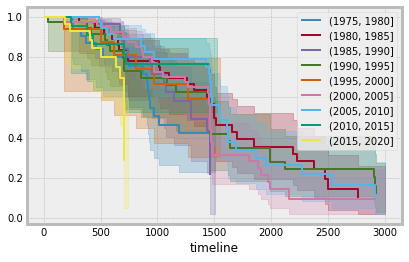

In [388]:
kmf = KaplanMeierFitter()

ax = plt.subplot()

for name, df_ in raw_df[['bin_year','event', 'T']].groupby('bin_year'):
    kmf.fit(df_['T'], df_['event'], label=name)
    ax = kmf.plot(ax=ax)
